# Laura del Carmen Cabal Paramo
Programacion Orientada a Objetos y Eventos - D

PROYECTO FINAL

In [ ]:
from google.colab import drive
#drive.mount('/content/drive') 

Importamos todas las librerías que usaremos:

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from timeit import default_timer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import joblib 
from tqdm import tqdm

Con la función listdir() obtenemos una lista de nombres de todos los archivos que podemos encontrar en cierta ruta dada. En este caso, leeremos las imágenes que usaremos para entrenar el modelo.


In [ ]:
Lista_caras_no_sonriendo  = os.listdir('/content/drive/MyDrive/SMILEs/negatives7')
Lista_caras_sonriendo = os.listdir('/content/drive/MyDrive/SMILEs/positives7')

************************************************************************************************************************************************************************************************************************************************
##*Caras* NO sonriendo

Antes de empezar, creamos etiquetas para cada imagen, donde 0 es no sonriendo y 1 es sonriendo.

Después en una lista llamada caras_no_sonriendo, con imread leemos y anexamos cada imagen que usaremos de la carpeta de caras no sonriendo (9476 imagenes)

In [ ]:
#print(Lista_caras_no_sonriendo)
Ruta_cara_no_sonriendo = '/content/drive/MyDrive/SMILEs/negatives7/'
Ruta_cara_sonriendo = '/content/drive/MyDrive/SMILEs/positives7/'

caras_no_sonriendo = []

etiquetas_no_sonriendo = np.zeros(len(Lista_caras_no_sonriendo),dtype=int)
etiquetas_sonriendo = np.ones(len(Lista_caras_sonriendo),dtype=int)


for i in tqdm(Lista_caras_no_sonriendo):  #[:,:.0]
  caras_no_sonriendo.append(cv2.imread(Ruta_cara_no_sonriendo+i)) # Leemos todas las imagenes donde no se sonrie

100%|██████████| 9476/9476 [02:56<00:00, 53.70it/s] 


Aqui estamos checando que forma tienen nuestras imagenes, es una matriz de 64*64 con 3 canales RGB. Pero queremos y debemos leer nuestras imagenes en blanco y negro.

In [ ]:
caras_no_sonriendo[990].shape

(64, 64, 3)

#############################################################################
Nos dimos cuenta que una de las imagenes traía errores, ya que al querer hacer un ciclo for para cambiar nuestras imagenes a 2 canales (blanco y negro) , no funcionaba y esto era debido a que no tenía el tamaño o forma de las demás imágenes.

Realizamos un for para checar que elemento de nuestra lista era la del error, nos imprime que numero de imagen es la que no tiene la misma forma que la de las demas.

In [ ]:
for i, no_sonriendo in enumerate(caras_no_sonriendo):
  if type(no_sonriendo) != type(np.array([1])):
    print(i)

991


Eliminamos la imagen 991, ya que esta es la que trae problemas y debemos descartarla del modelo ya que no aporta nada.

In [ ]:
removed_element = caras_no_sonriendo.pop(991)

print('Removed Element:', removed_element)
caras_no_sonriendo[991].shape

Removed Element: None


(64, 64, 3)

Ya eliminado, convertimos las imagenes a blanco y negro.

In [ ]:
for i in range(len(caras_no_sonriendo)):
  caras_no_sonriendo[i] = caras_no_sonriendo[i][:,:,0]

Con este for mostramos las primeras 5 imágenes solo para checar que todo esté correcto y al final imprimimos cúantas imagenes no sonriendo estaremos usando al final.

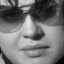

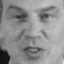

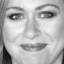

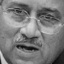

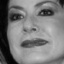

9475


In [ ]:
for i in range(5):
  cv2_imshow(caras_no_sonriendo[i])
print(len(caras_no_sonriendo))

Checamos que ahora la forma de las imagenes sea la correcta.

In [ ]:
caras_no_sonriendo[0].shape

(64, 64)

Ya que eliminamos una imagen, debemos eliminar una etiqueta.

In [ ]:
#como eliminamos un elemento,
etiquetas_no_sonriendo = np.zeros(len(caras_no_sonriendo),dtype=int)


************************************************************************************************************************************************************************************************************************************************
## *Caras* sonriendo:

Realizamos lo mismo que con las caras no sonriendo, pero ahora solo contamos con 3700 imágenes. Hay una diferencia significativa en el numero, por lo que el modelo se va a inclinar más a predecir que sea una cara no sonriendo.

En estas imágenes, no encontramos ningun error.

In [ ]:
caras_sonriendo = []

for i in tqdm(Lista_caras_sonriendo):
  caras_sonriendo.append(cv2.imread(Ruta_cara_sonriendo+i)) # Leemos todas las imagenes donde se sonrie 

100%|██████████| 3700/3700 [12:05<00:00,  5.10it/s]


In [ ]:
for i in range(len(caras_sonriendo)):
  caras_sonriendo[i] = caras_sonriendo[i][:,:,0]

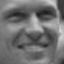

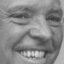

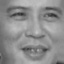

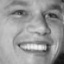

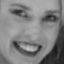

3700


In [ ]:
for i in range(5):
  cv2_imshow(caras_sonriendo[i])
print(len(caras_sonriendo))

In [ ]:
caras_sonriendo[56].shape

(64, 64)

In [ ]:
#prueba = np.squeeze(caras_no_sonriendo, axis = None)
#prueba.shape

In [ ]:
#print(caras_sonriendo, caras_no_sonriendo.shape)

In [ ]:
#for i, no_sonriendo in enumerate(caras_no_sonriendo):
#  if no_sonriendo.shape!=caras_no_sonriendo[0].shape:
#    print(i)

Aqui solo confirmamos que tengan la misma forma

In [ ]:
print(caras_sonriendo[1677].shape)
print(caras_no_sonriendo[1865].shape)

(64, 64)
(64, 64)


Convertimos ambas listas a un arreglo de numpy para poder concatenarlas.

In [ ]:
caras_sonriendo=np.array(caras_sonriendo)
#caras_no_sonriendo = np.delete(caras_no_sonriendo, 991)
caras_no_sonriendo=np.array(caras_no_sonriendo)

Unimos nuestras listas de caras y de etiquetas.

In [ ]:
caras = np.concatenate((caras_no_sonriendo,caras_sonriendo))
etiquetas = np.concatenate((etiquetas_no_sonriendo,etiquetas_sonriendo))

##HOG

El histograma de gradientes orientados (HOG) nos ayuda a describir caracteristicas que nos ayuden a detectar objetos. La técnica consiste en obtener las ocurrencias de orientación de gradiente en partes localizadas de una imagen. 
Esto queda más claro si lo observamos en una imagen.

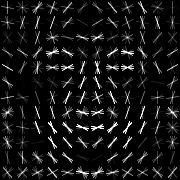

Para el proyecto, usamos estos HOG para encontrar las curvaturas y orientaciones de una sonrisa, para asi detectarla.

Los HOG los utilizamos en Procesamiento Digital de Imagenes e Inteligencia Artificial principalmente.

Creamos una lista donde guardaremos los histogramas de las caras:

In [ ]:
hog_caras = []
for i in tqdm(caras):
  hog_caras.append(hog(i,cells_per_block=(2, 2)))

100%|██████████| 13175/13175 [00:29<00:00, 441.65it/s]


Aqui solo estamos checando que datos nos arroja el histograma

In [ ]:
for i in range(3):
  print(hog_caras[i], len(hog_caras[i]))

[0.20736773 0.02110211 0.         ... 0.         0.00604666 0.01173102] 1764
[0.3393213  0.09873527 0.01097833 ... 0.00890723 0.06485609 0.21657809] 1764
[0.22918914 0.10710255 0.07120452 ... 0.01989785 0.03971588 0.09417944] 1764


Para dar una idea de que estamos obteniendo, realizamos un histograma con los datos obtenidos para cada imagen. Solo estamos imprimiendo una debido a que son muchas imagenes con las cuales estamos trabajando.

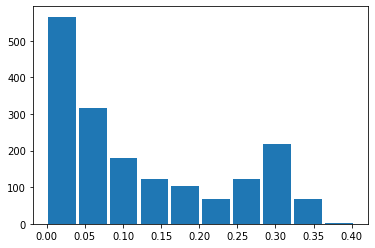

In [ ]:
plt.hist(hog_caras[0], rwidth = 0.9)
plt.show()

Imprimimos el tamaño de lista de etiquetas y de los histogramas. Solo para confirmar que todo esté correcto.

In [ ]:
print(len(etiquetas))
print(len(hog_caras))

13175
13175


Aqui empezamos a entrenar el modelo.

train_test_split() sirve para dividir arreglos o matrices en subconjuntos aleatorios de prueba y de entrenamiento.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(hog_caras,etiquetas, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [ ]:
print(X_train[0])

[0.17898856 0.29395027 0.20391047 ... 0.01007102 0.0265946  0.03055594]


## Máquinas de Vectores de Soporte (SVM):

Los SVM son más fáciles de explicar para problemas de clasificación, es decir, estos surgen para encontrar la manera óptima de clasificar.

Los vectores de soporte son los puntos que definen el margen máximo de separación del hiperplano que separa las clases.

Estos se usan mayormente para machine learning, de donde surge su nombre.

https://www.iartificial.net/maquinas-de-vectores-de-soporte-svm/

Una vez que se entrena el modelo, se realiza la prueba mediante el uso de datos que se obtienen del proceso de entrenamiento. Aqui compararamos las predicciones del modelo entrenado con los valores reales. La matriz de confusión nos ayuda a evaluar el éxito de un problema de clasificación y dónde se cometen errores (es decir, dónde se vuelve "confuso").
Aqui las usamos para evaluar el éxito de nuestro problema de calificación de sonrisa y no sonrisa.

              precision    recall  f1-score   support

     clase 0       0.94      0.96      0.95       955
     clase 1       0.89      0.83      0.86       362

    accuracy                           0.93      1317
   macro avg       0.92      0.90      0.91      1317
weighted avg       0.93      0.93      0.93      1317

Tiempo de entrenamiento:  1  minutos con  7.42589918900012  segundos


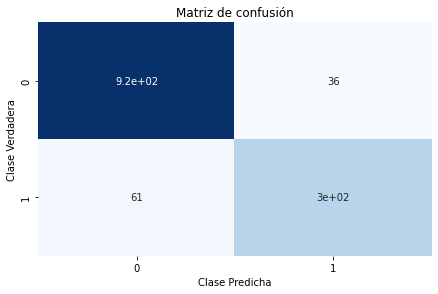

In [ ]:
inicio = default_timer() # Es para obtener el tiempo de entrenamiento
svm = SVC(kernel='poly', degree= 5, class_weight='balanced').fit(X_train,y_train)
fin =  default_timer()
y_predict = svm.predict(X_valid) # Predecimos las etiquetas de los datos de validación
target_names = ['clase 0', 'clase 1'] 
print(classification_report(y_valid, y_predict, target_names=target_names)) # Obtenemos metricas como: Precision, recall, f1-score, support, Accuracy
print("Tiempo de entrenamiento: ", int((fin-inicio)/60), ' minutos con ', (fin-inicio)%60,' segundos') # Colocamos el tiempo en minutos y segundos
matrix = confusion_matrix(y_valid, y_predict) # Obtenemos la matriz de confusión
df = pd.DataFrame(matrix, index=['0','1'], columns=['0','1']) # Las siguientes lineas son para mostrar la matriz de confusión de forma gráfica
sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase Predicha")
plt.show()

              precision    recall  f1-score   support

     clase 0       0.95      0.95      0.95       955
     clase 1       0.88      0.85      0.87       362

    accuracy                           0.93      1317
   macro avg       0.91      0.90      0.91      1317
weighted avg       0.93      0.93      0.93      1317

Tiempo de entrenamiento:  1  minutos con  7.4922382700001435  segundos


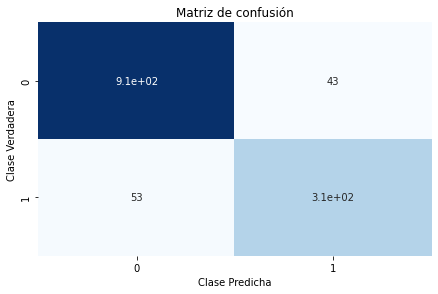

In [ ]:
inicio = default_timer()
svm_2 = SVC(C=3,class_weight='balanced').fit(X_train,y_train) # En esta maquina de soporte se usa un kernel radial
fin =  default_timer()
y_predict_2 = svm_2.predict(X_valid)
print(classification_report(y_valid, y_predict_2, target_names=target_names))
print("Tiempo de entrenamiento: ", int((fin-inicio)/60), ' minutos con ', (fin-inicio)%60,' segundos')
matrix_2 = confusion_matrix(y_valid, y_predict_2)
df_2 = pd.DataFrame(matrix_2, index=['0','1'], columns=['0','1'])
sns.heatmap(df_2, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase Predicha")
plt.show()

              precision    recall  f1-score   support

     clase 0       0.92      0.95      0.94       955
     clase 1       0.86      0.79      0.82       362

    accuracy                           0.91      1317
   macro avg       0.89      0.87      0.88      1317
weighted avg       0.91      0.91      0.91      1317

Tiempo de entrenamiento:  0  minutos con  1.174751045999983  segundos


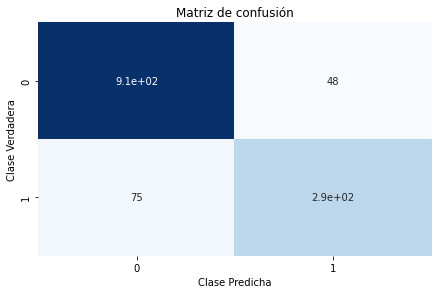

In [ ]:
inicio = default_timer()
svm_3 = LinearSVC(C=0.01).fit(X_train,y_train) # Se usa una maquina lineal
fin =  default_timer()
y_predict_3 = svm_3.predict(X_valid)
print(classification_report(y_valid, y_predict_3, target_names=target_names))
print("Tiempo de entrenamiento: ", int((fin-inicio)/60), ' minutos con ', (fin-inicio)%60,' segundos')
matrix_3 = confusion_matrix(y_valid, y_predict_3)
df_3 = pd.DataFrame(matrix_3, index=['0','1'], columns=['0','1'])
sns.heatmap(df_3, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase Predicha")
plt.show()

###Prueba de Modelo:

              precision    recall  f1-score   support

     clase 0       0.93      0.95      0.94       950
     clase 1       0.87      0.81      0.84       368

    accuracy                           0.91      1318
   macro avg       0.90      0.88      0.89      1318
weighted avg       0.91      0.91      0.91      1318



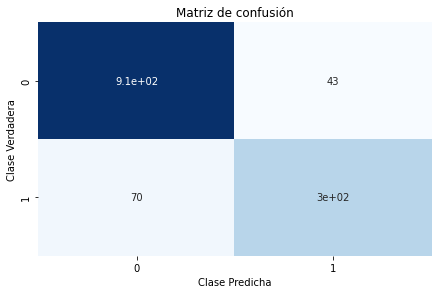

In [ ]:
y_predict_test = svm.predict(X_test)
print(classification_report(y_test, y_predict_test, target_names=target_names))
matrix_test = confusion_matrix(y_test, y_predict_test)
df_test = pd.DataFrame(matrix_test, index=['0','1'], columns=['0','1'])
sns.heatmap(df_test, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase Predicha")
plt.show()

              precision    recall  f1-score   support

     clase 0       0.94      0.95      0.94       950
     clase 1       0.86      0.84      0.85       368

    accuracy                           0.92      1318
   macro avg       0.90      0.89      0.90      1318
weighted avg       0.92      0.92      0.92      1318



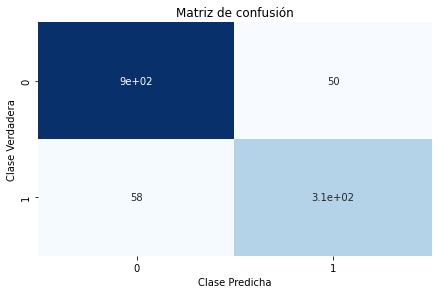

In [ ]:
y_predict_test_2 = svm_2.predict(X_test)
print(classification_report(y_test, y_predict_test_2, target_names=target_names))
matrix_test_2 = confusion_matrix(y_test, y_predict_test_2)
df_test_2 = pd.DataFrame(matrix_test_2, index=['0','1'], columns=['0','1'])
sns.heatmap(df_test_2, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase Predicha")
plt.show()

              precision    recall  f1-score   support

     clase 0       0.92      0.96      0.94       950
     clase 1       0.87      0.79      0.83       368

    accuracy                           0.91      1318
   macro avg       0.90      0.87      0.88      1318
weighted avg       0.91      0.91      0.91      1318



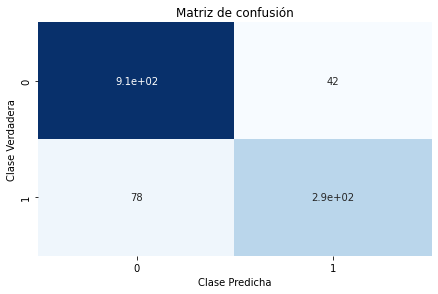

In [ ]:
y_predict_test_3 = svm_3.predict(X_test)
print(classification_report(y_test, y_predict_test_3, target_names=target_names))
matrix_3 = confusion_matrix(y_test, y_predict_test_3)
df_test_3 = pd.DataFrame(matrix_3, index=['0','1'], columns=['0','1'])
sns.heatmap(df_test_3, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase Predicha")
plt.show()

##Guardamos modelo para usarlo después

Una vez que ya se entrenó y tiene listo el modelo, lo guardamos para usarlo después.

In [ ]:
joblib.dump(svm, 'SMILEs.pkl')

['SMILEs.pkl']

Usando el modelo y 2 imagenes prueba para probar el modelo.

In [ ]:
modelo = joblib.load('/content/drive/MyDrive/SMILEs/SMILEs.pkl')
Imagen_prueba_1 = cv2.imread('/content/drive/MyDrive/SMILEs/negatives7/9830.jpg')
Imagen_prueba_2 = cv2.imread('/content/drive/MyDrive/SMILEs/positives7/10080.jpg')

##Prueba de modelo

Usamos el modelo y la imagen prueba de no sonriendo para detectar si funciona el modelo, nos imprime 0 si no sonrie y 1 si sí.

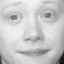

[0]


In [ ]:
cv2_imshow(Imagen_prueba_1)
#hog_1 = [hog(Imagen_prueba_1)] #Si se usa el primer clasificador
hog_1 = [hog(Imagen_prueba_1,cells_per_block=(2, 2))] # Si se usa el segundo clasificador
print(modelo.predict(hog_1))

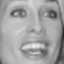

[1]


In [ ]:
cv2_imshow(Imagen_prueba_2)
#hog_2 = [hog(Imagen_prueba_2)] #Si se usa el primer clasificador
hog_2 = [hog(Imagen_prueba_2,cells_per_block=(2, 2))] # Si se usa el segundo clasificador
print(modelo.predict(hog_2))

##Detectar Cara

Intenté detcatar la cara usando cascade, el siguiente código es algo que encontré en internet, pero no logré hacer que me funcionara. Solo lo dejaré para intentar en algun futuro a ver si ahora si puedo lograr que funcione.

In [ ]:
cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')#cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cascade_eye = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')#cv2.CascadeClassifier('haarcascade_eye.xml') 
cascade_smile = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
#face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [ ]:
#from google.colab.patches import cv2_imshow

def detection(grayscale, img):
    face = cascade_face.detectMultiScale(grayscale, 1.3, 5)
    for (x_face, y_face, w_face, h_face) in face:
        cv2.rectangle(img, (x_face, y_face), (x_face+w_face, y_face+h_face), (255, 130, 0), 2)
        ri_grayscale = grayscale[y_face:y_face+h_face, x_face:x_face+w_face]
        ri_color = img[y_face:y_face+h_face, x_face:x_face+w_face] 
        eye = cascade_eye.detectMultiScale(ri_grayscale, 1.2, 18) 
        for (x_eye, y_eye, w_eye, h_eye) in eye:
            cv2.rectangle(ri_color,(x_eye, y_eye),(x_eye+w_eye, y_eye+h_eye), (0, 180, 60), 2) 
        smile = cascade_smile.detectMultiScale(ri_grayscale, 1.7, 20)
        for (x_smile, y_smile, w_smile, h_smile) in smile: 
            cv2.rectangle(ri_color,(x_smile, y_smile),(x_smile+w_smile, y_smile+h_smile), (255, 0, 130), 2)
    return img 

##Parte de la cámara

Lo que debemos hacer es:

Segunda Parte: 

Utiliza la webcam de tu computadora y el clasificador Haar preentrenado de OpenCV, haarcascade_frontalface_default.xml, para extraer el rostro de tu cara. Dicha sección del rostro deberás transformarla a tono de grises y redimencionarla a tamaño 64x64, ya que es el tamaño de las imágenes con las cuales fue generado el clasificador en la primera parte. 

Extraer las características de HOG de la sección de rostro segmentada. 

Utilizar el mejor de tus clasificadores para hacer la predicción de “sonríe” o “no-sonríe”. Muestra en la pantalla de la webcam la etiqueta “Sonriendo” o “No-sonriendo” dependiendo del estado predicho. 

Para colab, investigué cómo usar la cámara.

Debemos en la parte de "insert", agregar un "code snippet" que se llama "camara capture", que es lo que se muestra a continuación. Al momento de correrlo, usa la camara y debes presionar capture para tomar la imagen que usaremos para probar el modelo.

No logré encontrar la manera de poder hacer esto en tiempo real.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


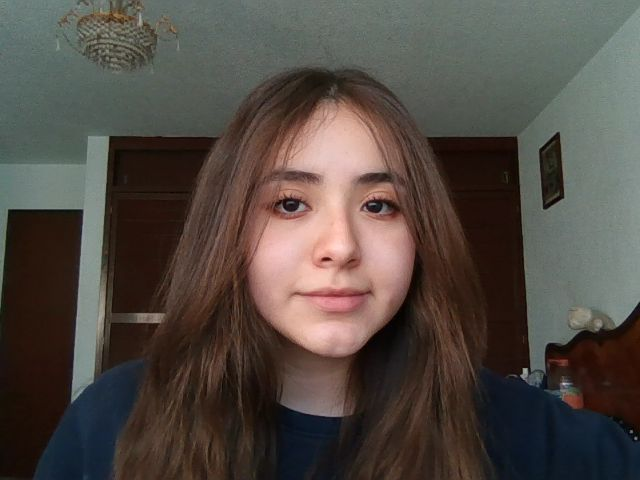

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Esto es un resumen muy pequeño de lo que realizamos con todas las imagenes anteriores. La leemos donde se guardó en colab, la pasamos a blanco y negro y finalmente la redimensionamos al tamaño de todas las demás imagenes. Imprimimos o mostramos para verificar que sea correcto.

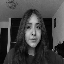

(64, 64)


In [ ]:
img = cv2.imread('/content/drive/MyDrive/SMILEs/photoprueba.jpg')
img = img[:,:,0]
imgcaptured_resize = cv2.resize(img, (64,64))
cv2_imshow(imgcaptured_resize)
print(imgcaptured_resize.shape)

Por último aplicamos el modelo.

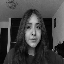

No sonriendo
[0]


In [ ]:
cv2_imshow(imgcaptured_resize)
#hog_1 = [hog(imgcaptured_resize)] #Si se usa el primer clasificador
hog_1 = [hog(imgcaptured_resize,cells_per_block=(2, 2))] # Si se usa el segundo clasificador
if modelo.predict(hog_1) == 0:
  print("No sonriendo")
else:
  print("Sonriendo")
print(modelo.predict(hog_1))

Noté que en mis imagenes de prueba, cuando sonreía no me detectaba la sonrisa, siempre me ponía un 0. No sé si es debido a que la imagen no es tan cercana como todas las demas que usamos de prueba, o debido a que no se entrenó bien el modelo, ya que como mencioné anteriormente, las imagenes para entrenar el modelo tenian una diferencia muy significativa, 9000 de no sonriendo y 3000 de sonriendo.